 Dataset Link: https://www.kaggle.com/t/eef896d3115a4e2281f85ab9bdc9ad97

In [25]:
import os
os.environ['KAGGLE_USERNAME'] = "richadwivedi"
os.environ['KAGGLE_KEY'] = "1462d815580695348ef4bf8d3edfbfbe"

!kaggle competitions download -c bdmh2021-a2

RNA_Train.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
sample_submission.csv: Skipping, found more recently modified local copy (use --force to force download)
test.csv: Skipping, found more recently modified local copy (use --force to force download)


IMPORT STATEMENTS


In [26]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as map
import matplotlib.pyplot as plt
from sklearn.metrics import matthews_corrcoef
from imblearn.under_sampling import RandomUnderSampler
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import resample

from collections import Counter

from sklearn.preprocessing import LabelEncoder
from zipfile import ZipFile


#To ignore warnings.
import warnings
warnings.filterwarnings('ignore')

#saving model
from sklearn.externals import joblib

LOADING DATASET

In [27]:
def loading_dataset():
    #loading train and test data
    with ZipFile('RNA_Train.csv.zip', 'r') as zipObj:
        zipObj.extractall()
    #Reading CSV Files
    train= pd.read_csv('RNA_Train.csv')
    test= pd.read_csv('test.csv')

    return train,test

train,test=loading_dataset()

In [28]:
print("Training Data")
train.head()

Training Data


,Sequence,label
0,XXXXXXXXMLQLVRAGA,0
1,XXXXXXXMLQLVRAGAR,0
2,XXXXXXMLQLVRAGART,0
3,XXXXXMLQLVRAGARTW,0
4,XXXXMLQLVRAGARTWF,0


In [29]:
print("Test Data")
test.head()

Test Data


,Sequence
0,XXXXXXXXSEVSDTNLY
1,XXXXXXXSEVSDTNLYS
2,XXXXXXSEVSDTNLYSP
3,XXXXXSEVSDTNLYSPF
4,XXXXSEVSDTNLYSPFK


DATA OVERVIEW

In [30]:
print("Shape of the Data ", train.shape)

#Number of Rows in the dataset
print("Number of Rows are:",train.shape[0])

#Number of Columns/features in dataset
print("Number of Columns are:",train.shape[1])

#List of Available features in dataset
print("Available Features are:",train.columns.tolist())

Shape of the Data  (330862, 2)
Number of Rows are: 330862
Number of Columns are: 2
Available Features are: ['Sequence', 'label']


In [31]:
# Checking type of Value are Available in Features.
print(train.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 330862 entries, 0 to 330861
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   Sequence  330862 non-null  object
 1   label     330862 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 5.0+ MB
None


In [32]:
#Checking is data contains any null/nan values
print(train.isnull().sum())

Sequence    0
label       0
dtype: int64


0    291963
1     38899
Name: label, dtype: int64


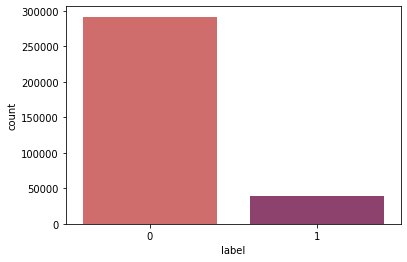

In [33]:
#Let's check our target class "label" is balanced or not
print(train["label"].value_counts())
# since their are 291963 values of class 0 and 38899 values of class 1.
#so the class is highly unbalanced

#Visualization of unbalanced class
sns.countplot(train["label"],palette="flare")


ENCODING SEQUENCE FEATURE

In [34]:
#As sequence feature is categorical so we need to convert it into numerical vale to use these for training in machine learning models

#Finding unique list and total number of unique alphabets 

list_single_pattern=[]
for seq in train['Sequence']:
  list_single_pattern.append(list(set(seq)))

flat_list = [item for sublist in list_single_pattern for item in sublist]
newlist=list(set(flat_list))

print("Number of Unique alphabets: ",len(newlist))
print("\nlist of unique alphabets:")
print(newlist)

Number of Unique alphabets:  21

list of unique alphabets:
['L', 'M', 'Y', 'R', 'A', 'X', 'N', 'H', 'F', 'V', 'T', 'E', 'S', 'K', 'D', 'I', 'C', 'P', 'W', 'Q', 'G']


In [35]:
#Converting the list of alphabets in dictionary an alloting unique number as label to each alphabet

unique_dict = {}
for index, val in enumerate(newlist):
    unique_dict[val] = index+1
print("Encoded alphabets of RNA Sequence:")
print(unique_dict)


Encoded alphabets of RNA Sequence:
{'L': 1, 'M': 2, 'Y': 3, 'R': 4, 'A': 5, 'X': 6, 'N': 7, 'H': 8, 'F': 9, 'V': 10, 'T': 11, 'E': 12, 'S': 13, 'K': 14, 'D': 15, 'I': 16, 'C': 17, 'P': 18, 'W': 19, 'Q': 20, 'G': 21}


In [36]:
#Encoding sequences in a train and test data into numerical values

def encode_data(df):

  encoded_list = []
  for i in df['Sequence'].values:
    encode_val = []
    for value in i:
      encode_val.append(unique_dict.get(value, 0))
    encoded_list.append(np.array(encode_val))
  
  return encoded_list


In [37]:
train_encoded = encode_data(train) 
test_encoded = encode_data(test)

In [38]:
#data after encoding
print("encoded training data:")
train_encoded

encoded training data:


[array([ 6,  6,  6,  6,  6,  6,  6,  6,  2,  1, 20,  1, 10,  4,  5, 21,  5]),
 array([ 6,  6,  6,  6,  6,  6,  6,  2,  1, 20,  1, 10,  4,  5, 21,  5,  4]),
 array([ 6,  6,  6,  6,  6,  6,  2,  1, 20,  1, 10,  4,  5, 21,  5,  4, 11]),
 array([ 6,  6,  6,  6,  6,  2,  1, 20,  1, 10,  4,  5, 21,  5,  4, 11, 19]),
 array([ 6,  6,  6,  6,  2,  1, 20,  1, 10,  4,  5, 21,  5,  4, 11, 19,  9]),
 array([ 6,  6,  6,  2,  1, 20,  1, 10,  4,  5, 21,  5,  4, 11, 19,  9,  4]),
 array([ 6,  6,  2,  1, 20,  1, 10,  4,  5, 21,  5,  4, 11, 19,  9,  4, 18]),
 array([ 6,  2,  1, 20,  1, 10,  4,  5, 21,  5,  4, 11, 19,  9,  4, 18, 13]),
 array([ 2,  1, 20,  1, 10,  4,  5, 21,  5,  4, 11, 19,  9,  4, 18, 13, 21]),
 array([ 1, 20,  1, 10,  4,  5, 21,  5,  4, 11, 19,  9,  4, 18, 13, 21, 17]),
 array([20,  1, 10,  4,  5, 21,  5,  4, 11, 19,  9,  4, 18, 13, 21, 17,  4]),
 array([ 1, 10,  4,  5, 21,  5,  4, 11, 19,  9,  4, 18, 13, 21, 17,  4, 21]),
 array([10,  4,  5, 21,  5,  4, 11, 19,  9,  4, 18, 13, 21, 17, 

In [39]:
#Converting obtained data into dataframe

#Converting train data
train_df=pd.DataFrame(train_encoded)
train_df["label"]=train["label"]

#Converting test data
test_df=pd.DataFrame(test_encoded)

In [40]:
#Dataframe obtained after encoding
print("encoded training dataframe:")
train_df

encoded training dataframe:


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,label
0,6,6,6,6,6,6,6,6,2,1,20,1,10,4,5,21,5,0
1,6,6,6,6,6,6,6,2,1,20,1,10,4,5,21,5,4,0
2,6,6,6,6,6,6,2,1,20,1,10,4,5,21,5,4,11,0
3,6,6,6,6,6,2,1,20,1,10,4,5,21,5,4,11,19,0
4,6,6,6,6,2,1,20,1,10,4,5,21,5,4,11,19,9,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
330857,5,14,18,12,21,11,9,14,1,10,5,2,1,6,6,6,6,0
330858,14,18,12,21,11,9,14,1,10,5,2,1,6,6,6,6,6,0
330859,18,12,21,11,9,14,1,10,5,2,1,6,6,6,6,6,6,0
330860,12,21,11,9,14,1,10,5,2,1,6,6,6,6,6,6,6,0


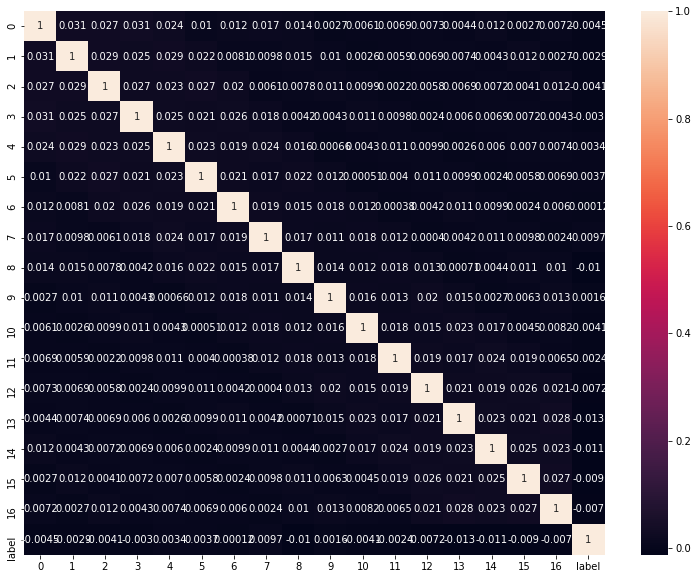

In [41]:
plt.subplots(figsize=(13,10))

#Visulazing the correlation between all the features
#sns.heatmap(df.corr(method='pearson'), annot = True)
sns.heatmap(train_df.corr(), annot = True)

DATA BALANCING

1    291963
0    291963
Name: label, dtype: int64


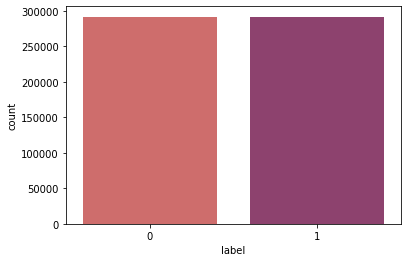

In [42]:
def data_balancing(df):
    #Function for handling class imbalance.
    
    df_majority = df[df.label==0]
    df_minority = df[df.label==1]

    #Resampling data.
    traindf = resample(df_minority, replace=True,  n_samples=df_majority.shape[0], random_state=42) 

    # concatenating resampled class with orginal training data.
    train1 = pd.concat([df_majority, traindf])

    return train1

train1=data_balancing(train_df)

# Display new class counts
print(train1.label.value_counts())

#Visualization after balancing 
sns.countplot(train1["label"],palette="flare")

In [43]:
#Spliing into x_train and y_train for testing purpose.

def split(df):
    y_train=df["label"]
    x_train=df.drop("label",axis=1)

    return x_train,y_train

x_train,y_train=split(train1)

# print(x_train)
# print(y_train)

TRAINING DATA

In [44]:
def train_data(x_train,y_train):

    #https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

    #Applying random forest classifier.
    clf = RandomForestClassifier(n_estimators=100)
    #Training model.
    clf.fit(x_train,y_train)
    #Saving model in pickel file.
    joblib.dump(clf, '/content/drive/MyDrive/bdmh_assignment2/random_forest.pkl')

    return clf

model=train_data(x_train,y_train)

In [45]:
def test_data(model,test_data):
    #Predicting RNA sequence is interacting or non interacting on test data.
    y_pred=model.predict(test_data)

    #Loading new test csv and creating dataframe result to store the sequences along with predicted values.
    test_new=pd.read_csv('test.csv')
    result=pd.DataFrame({"Sequence":test_new["Sequence"],"label":y_pred})
    # print(result)
    #Converting the result dataframe into csv.
    result.to_csv('/content/drive/MyDrive/bdmh_assignment2/random_forest_acc.csv',index=False)
    #prinitng number of one's and zero's in predicted result.
    print(Counter(y_pred))

    return y_pred

y_pred=test_data(model,test_df)

Counter({0: 5729, 1: 547})
